# **Rotary Potion Embedding (RoPE) with Triton**

In [1]:
"""Attention."""
import collections
from contextlib import nullcontext
import functools
# from importlib.metadata import version
import math
import os
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
import warnings

import numpy as np
# from pkg_resources import packaging

import pytest
import torch
import torch.nn.functional as F

### **RoPE in Pytoch from TransformerEngine**

In [2]:
class RotaryPositionEmbedding(torch.nn.Module):
    """
    Implements Rotary Position Embedding from https://arxiv.org/abs/2104.09864.
    """
    def __init__(
        self,
        dim: int,
        rotary_percent: float = 1.0,
        seq_len_interpolation_factor: Optional[int] = None,
        pretrained_max_position_embeddings: Optional[int] = None,
    ):
        """
        Parameters
        ----------
        dim: int
            rotary embedding dimension
        rotary_percent: float
            Percent of rotary dimension to use for rotary position embeddings.
        seq_len_interpolation_factor: int
            if not None, discrete positions will be interpolated by this factor via the trick in
            https://arxiv.org/abs/2306.15595
        pretrained_max_position_embeddings: int
            pre-trained max_position_embeddings before position interpolation
        """
        super().__init__()
        if rotary_percent < 1.0:
            dim = int(dim * rotary_percent)
        self.seq_len_interpolation_factor = seq_len_interpolation_factor
        inv_freq = 1.0 / (
            10000
            ** (
                torch.arange(0, dim, 2, dtype=torch.float32, device=torch.cuda.current_device())
                / dim
            )
        )
        self.register_buffer('inv_freq', inv_freq)
        self.pretrained_max_position_embeddings = pretrained_max_position_embeddings

    def forward(self, max_seq_len: int, offset: int = 0):
        """
        Create rotary position embedding frequencies

        Parameters
        ----------
        max_seq_len: int
            sequence length of a sample
        offset: int, default = 0
            fixed offset for freqencies
        """
        seq = (
            torch.arange(max_seq_len, device=self.inv_freq.device, dtype=self.inv_freq.dtype)
            + offset
        )

        if (self.pretrained_max_position_embeddings is not None
            and self.seq_len_interpolation_factor is not None):
            if (max_seq_len >
                self.pretrained_max_position_embeddings * self.seq_len_interpolation_factor):
                # dynamic linear scaling (length > position we have learned)
                seq *= 1 / (max_seq_len / self.pretrained_max_position_embeddings)
            else:
                # fixed linear scaling
                seq *= 1 / self.seq_len_interpolation_factor

        freqs = torch.einsum('i , j -> i j', seq, self.inv_freq)
        # first part even vector components, second part odd vector components,
        #  2 * dim in dimension size
        emb = torch.cat((freqs, freqs), dim=-1)
        # emb [seq_length, .., dim]
        return emb.reshape(emb.size(0), 1, 1, emb.size(1))

def _rotate_half(x: torch.Tensor) -> torch.Tensor:
    """
    change sign so the last dimension becomes [-odd, +even]
    """
    x = x.view(x.shape[:-1] + torch.Size((2, x.shape[-1] // 2)))
    x1, x2 = x.unbind(dim=-2)
    return torch.cat((-x2, x1), dim=-1)


def apply_rotary_pos_emb(
    t: torch.Tensor,
    freqs: torch.Tensor,
    tensor_format: str = "sbhd",
    fused: bool = False,
    cu_seqlens: Union[torch.Tensor, None] = None,
) -> torch.Tensor:
    """
    Apply rotary positional embedding tensor to the input tensor.

    Parameters
    ----------
    t: torch.Tensor
        Input tensor of shape `[s, b, h, d]`, `[s, b, h, d]` or `[t, h, d]`, on which
        rotary positional embedding will be applied.
    freqs: torch.Tensor
        Rotary positional embedding tensor of shape `[s2, 1, 1, d2]` and dtype 'float',
        with `s2 >= s` and `d2 <= d`.
    fused: bool, default = False
        Whether to use a fused applying RoPE implementation.
    tensor_format: {'sbhd', 'bshd', 'thd'}, default = 'sbhd'
        is `bshd` if `t` is of shape `[bs, seq, ...]`, or `sbhd` if `t` is
        of shape `[seq, bs, ...]`. 'thd' is only supported when `fused` is True.
    cu_seqlens: torch.Tensor, default = None.
        Cumulative sum of sequence lengths in a batch for `t`, with shape [b + 1] and
        dtype torch.int32. Only valid when `tensor_format` is 'thd'.
    """
#     if fused:
#         assert (
#             tensor_format != "thd" or cu_seqlens is not None
#         ), "cu_seqlens must not be None when tensor_format is 'thd'."
#         return FusedRoPEFunc.apply(t, freqs, tensor_format, cu_seqlens)

    assert tensor_format in ("sbhd", "bshd"), (
        "Only formats `sbhd` or `bshd` are supported for input tensor `t` "
        f"when fused is False, got {tensor_format}."
    )

    max_seq_len = freqs.shape[0]
    cur_seq_len = t.shape[1] if tensor_format == "bshd" else t.shape[0]

    # Only apply the rotary embeddings up to the sequence length of the running
    # input.
    assert cur_seq_len <= max_seq_len, (
        f"Rotary Embeddings only supported up to {max_seq_len} sequence length!"
    )
    freqs = freqs[:cur_seq_len]
    if tensor_format == "bshd":
        freqs = freqs.transpose(0, 1)  # [seq, 1, 1, dim] -> [1, seq, 1, dim]
    # cos/sin first then dtype conversion for better precision
    cos_ = torch.cos(freqs).to(t.dtype)
    sin_ = torch.sin(freqs).to(t.dtype)

    rot_dim = freqs.shape[-1]
    # ideally t_pass is empty so rotary pos embedding is applied to all tensor t
    t, t_pass = t[..., :rot_dim], t[..., rot_dim:]

    # first part is cosine component
    # second part is sine component, need to change signs with _rotate_half method
    t = (t * cos_) + (_rotate_half(t) * sin_)
    return torch.cat((t, t_pass), dim=-1)


In [3]:
def get_tol(dtype: torch.dtype) -> Dict:
    if dtype == torch.bfloat16:
        return dict(atol=1e-2, rtol=1e-2)
    elif dtype == torch.float16:
        return dict(atol=1e-3, rtol=1e-3)
    return dict(atol=1e-5, rtol=1.3e-6)


# Gradient is a broadcasted scalar
def _overlapping_grad(output: torch.Tensor) -> torch.Tensor:
    return output.sum() * 2

# Gradient is a full tensor
def _non_overlapping_grad(output: torch.Tensor) -> torch.Tensor:
    t = torch.ones_like(output)
    return torch.sum(output * t)

## **Triton**
### **RoPE Forward**
* RoPE에서 배치 간, 시퀀스 간, head 간 연산은 독립적이다. 하나의 임베딩 안에서 위치 변화(_rotate_half)를 하기 때문에 임베딩 내 연산만 메모리 접근 측면에서 독립적이지 않다.
따라서 BLOCK_SIZE를 RoPE 연산을 적용하는 임베딩 차원의 크기로 설정한다. rotate_percent에 따라 RoPE 연산을 적용하는 임베딩의 갯수가 다르기 때문에 입력 텐서 $t$의 차원이 아닌 frequency embedding의 차원 수로 설정한다. 이 경우 한 블록 내에서 [1,1,1, freq_embedding_dim]의 메모리 접근이 가능하고 스레드마다 하나의 output을 계산한다.
* 행렬 $\begin{equation}
   \begin{pmatrix} 
   \cos m\theta & -\sin m\theta\\
   \sin m\theta & \cos m\theta \\
   \end{pmatrix} 
\end{equation}
$로 임베딩을 회전 변환하면 $(x_1\cos m\theta - x_2\sin m\theta, x_2\cos m\theta + x_1\sin m\theta)$의 결과가 나온다.
여기서 sin, cos은 freq_emb(emb_ptr)을 순서대로 load하여 계산한다.
_rotate_half를 하기 위해 입력 텐서(t_ptr)을 각각 t0, t1에 절반씩 load한다.
out_ptr에 저장할 때 앞의 절반과 뒤의 절반의 연산이 다르기 때문에 각가 계산하여 다음과 같이 저장한다.

In [4]:
import triton
import triton.language as tl

@triton.jit
def rope_fwd(t_ptr, emb_ptr, out_ptr, seq_length, batch_size, head_num, hidden_size, BLOCK_SIZE:tl.constexpr):
    pid = tl.program_id(axis=0)

    t_start = pid * hidden_size
    emb_start = pid//(batch_size*head_num) * BLOCK_SIZE

    emb_off = emb_start + tl.arange(0, BLOCK_SIZE//2)
    emb = tl.load(emb_ptr + emb_off, mask = emb_off < seq_length*BLOCK_SIZE)
    _cos, _sin = tl.cos(emb), tl.sin(emb)
    
    t_off0 = t_start + tl.arange(0, BLOCK_SIZE//2)
    t_off1 = t_start + tl.arange(0, BLOCK_SIZE//2) + BLOCK_SIZE//2
    mask_t0 = t_off0 < (seq_length * batch_size * head_num * hidden_size)
    mask_t1 = t_off1 < (seq_length * batch_size * head_num * hidden_size)
    
    t0 = tl.load(t_ptr + t_off0, mask = mask_t0)
    t1 = tl.load(t_ptr + t_off1, mask = mask_t1)
    
    tl.store(out_ptr + t_off0, t0*_cos - t1*_sin, mask = mask_t0)
    tl.store(out_ptr + t_off1, t1*_cos + t0*_sin, mask = mask_t1)

### **RoPE Backward**
* RoPE forward와 마찬가지로 메모리 접근 측면에서 배치, 시퀀스, head 간 연산은 독립적이고 임베딩 간의 연산은 독립적이지 않기 때문에 BLOCK_SIZE를 frequency embedding의 차원 수로 설정한다.
* backpropagation은 행렬 $\begin{equation}
   \begin{pmatrix} 
   \cos m\theta & \sin m\theta\\
   -\sin m\theta & \cos m\theta \\
   \end{pmatrix} 
\end{equation}$로 회전변환하면 된다. 따라서 rope_fwd()에서 결과값을 저장하는 부분에서 sin 앞의 부호만 바꿔주면 된다.

In [5]:
@triton.jit
def rope_bwd(t_ptr, emb_ptr, out_ptr, seq_length, batch_size, head_num, hidden_size, BLOCK_SIZE:tl.constexpr):
    pid = tl.program_id(axis=0)

    t_start = pid * hidden_size
    emb_start = pid//(batch_size*head_num) * BLOCK_SIZE

    emb_off = emb_start + tl.arange(0, BLOCK_SIZE//2)
    emb = tl.load(emb_ptr + emb_off, mask = emb_off < seq_length*BLOCK_SIZE)
    _cos, _sin = tl.cos(emb), tl.sin(emb)

    t_off0 = t_start + tl.arange(0, BLOCK_SIZE//2)
    t_off1 = t_start + tl.arange(0, BLOCK_SIZE//2) + BLOCK_SIZE//2
    mask_t0 = t_off0 < (seq_length * batch_size * head_num * hidden_size)
    mask_t1 = t_off1 < (seq_length * batch_size * head_num * hidden_size)
    
    t0 = tl.load(t_ptr + t_off0, mask = mask_t0)
    t1 = tl.load(t_ptr + t_off1, mask = mask_t1)
    
    tl.store(out_ptr + t_off0, t0*_cos + t1*_sin, mask = mask_t0)
    tl.store(out_ptr + t_off1, t1*_cos - t0*_sin, mask = mask_t1)

### **RoPE Function**
* rotary_percent에 따라 rotation을 하는 텐서 비율이 달라진다. rotation을 안하는 경우는 기존의 input 텐서 값을 그대로 보존하기 때문에 rope_fwd, rope_bwd 커널에 넣기 전에 output 텐서 값을 input 텐서 값으로 초기화한다. (복사하지 않아도 되는 값도 불러오기 때문에 시간이 더 소모될 수 있다고 예상한다.)
* 가속화 하기 위해서는 BLOCK_SIZE를 1024에 가깝게 하는 게 좋다. 따라서 head_num도 같이 flatten하여 넣어주면 빨라질 것으로 예상하지만 시간 관계상 패스했다.
* forward에서 받은 t와 freqs 텐서를 backward에서 다시 사용하기 위해 ctx.save_for_backward()로 저장한다.
* BLOCK_SIZE는 freqs 텐서의 마지막 차원과 같은 크기로 지정한다.
* grid는 input 텐서의 모든 차원 값을 곱한 값에서 BLOCK_SIZE로 나눈 값과 같다.
* rope_fwd에서 출력된 텐서의 원소들의 메모리 주소가 연속적이지 않을 수 있다. 이를 해결하기 위해 contiguous()를 사용하여 정렬한다.

In [8]:
class tritonRoPE(torch.autograd.Function):

    @staticmethod
    def forward(ctx, t, freqs, tensor_format: str = "sbhd",
                cu_seqlens: Union[torch.Tensor, None] = None,):
        
        assert tensor_format in ("sbhd", "bshd"), (
            "Only formats `sbhd` or `bshd` are supported for input tensor `t` "
            f"when fused is False, got {tensor_format}."
        )
        # allocate output
        if tensor_format == "bshd":
            t = t.transpose(0, 1).contiguous()
            freqs = freqs.transpose(0, 1).contiguous()
            
        output = t.clone().detach()
        seq_length = t.shape[0]
        batch_size = t.shape[1]
        head_num = t.shape[2]
        hidden_size = t.shape[3]
        rot_dim = freqs.size()[-1]
        grid = lambda meta: (triton.cdiv(seq_length*batch_size*head_num*hidden_size, meta['BLOCK_SIZE']),)
        rope_fwd[grid](t, freqs, output, seq_length, batch_size, head_num, hidden_size, BLOCK_SIZE=rot_dim)
        
        if tensor_format == "bshd":
            output = output.transpose(0, 1)
            
        ctx.save_for_backward(freqs, cu_seqlens)
        ctx.tensor_format = tensor_format
        
        return output

    @staticmethod
    def backward(ctx, grad_output: torch.Tensor):
        freqs, cu_seqlens = ctx.saved_tensors
        if ctx.tensor_format == "bshd":
            grad_output = grad_output.transpose(0, 1).contiguous()
            
        grad_input = grad_output.clone().detach()    
        seq_length = grad_output.shape[0]
        batch_size = grad_output.shape[1]
        head_num = grad_output.shape[2]
        hidden_size = grad_output.shape[3]
        rot_dim = freqs.size()[-1]
        grad_output = grad_output.contiguous()
        grid = lambda meta: (triton.cdiv(seq_length*batch_size*head_num*hidden_size, meta['BLOCK_SIZE']),)
        rope_bwd[grid](grad_output, freqs, grad_input, seq_length, batch_size, head_num, hidden_size, BLOCK_SIZE=rot_dim)
        
        if ctx.tensor_format == "bshd":
            grad_input = grad_input.transpose(0, 1)
        return grad_input, None, None, None, None


### **Test RoPE**
TransformerEngine에 있는 RoPE와 Triton kernel의 RoPE의 결과가 동일한지 비교한다.

In [9]:
# @pytest.mark.parametrize("dtype", [torch.float32, torch.bfloat16, torch.float16])
# @pytest.mark.parametrize("seq_length", [2048, 4096])
# @pytest.mark.parametrize("hidden_size", [128, 256])
# @pytest.mark.parametrize("rotary_percent", [0.5, 1.0])
# @pytest.mark.parametrize("margin", [0, 10])
# @pytest.mark.parametrize("transpose", [None, (0, 1), (2, 3)])
# @pytest.mark.parametrize("tensor_format", ["sbhd", "bshd"])
# @pytest.mark.parametrize("loss_func", [_overlapping_grad, _non_overlapping_grad])
def test_fused_rope(
    dtype: torch.dtype,
    seq_length: int,
    hidden_size: int,
    rotary_percent: float,
    margin: int,
    transpose: Union[Tuple, None],
    tensor_format: str,
    loss_func: Callable,
) -> None:
    device = torch.device("cuda:0")
    batch_size, head_num = 2, 64
    t = torch.rand(
        (seq_length - margin, batch_size, head_num, hidden_size),
        dtype=dtype,
        device=device,
    )
    if tensor_format == "bshd":
        t = t.transpose(0, 1).contiguous()
    if transpose:
        t = t.transpose(*transpose).contiguous().transpose(*transpose)
    t.requires_grad = True

    rotary_pos_emb = RotaryPositionEmbedding(hidden_size, rotary_percent)
    emb = rotary_pos_emb(seq_length)

    # unfused
    output_unfused = apply_rotary_pos_emb(t, emb, tensor_format=tensor_format, fused=False)
    loss_unfused = loss_func(output_unfused)
    loss_unfused.backward()
    grad_unfused = t.grad.detach().clone()
    t.grad = None
    
    #print(t.shape, emb.shape, output_unfused.shape)
    
    # Triton
    output_triton = tritonRoPE.apply(t, emb, tensor_format, None)
    loss_triton = loss_func(output_triton)
    loss_triton.backward()
    grad_triton = t.grad.detach().clone()
    t.grad = None

    torch.testing.assert_close(output_triton, output_unfused)
    torch.testing.assert_close(grad_triton, grad_unfused)

    
test_fused_rope(torch.float32, 2048, 128, 0.5, 10, None, "sbhd", _overlapping_grad)
test_fused_rope(torch.float32, 2048, 128, 1.0, 0, None, "sbhd", _overlapping_grad)
print("########## PASSED ##########")

########## PASSED ##########


### **Compare the Performance**
시퀀스 길이(sequence_length)에 따른 Pytorch, Triton kernel, CUDA kernel로 작성한 RoPE의 성능을 비교했다. 배치 사이즈는 4, head 개수는 64, hidden_size는 128로 고정하고, sequence_length를 1280부터 4096까지 128씩 증가하여 성능을 확인했다. 모든 sequence length에 대해 Triton kernel이 기본 Pytorch 코드보다 forward와 backward 모두 2배 정도 빠른 것을 확인할 수 있다.  
sequence_length를 x_vals로 주었지만, 배치 사이즈(batch_size), head의 개수(head_num), 임베딩 차원(hidden_size) 등으로 설정하여 이에 따른 성능도 확인할 수 있다.  

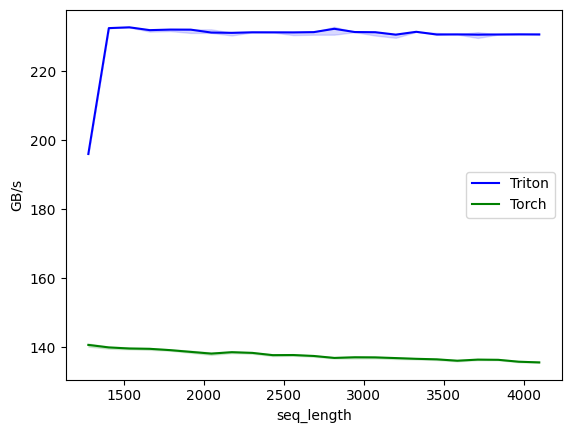

RoPE performance:
    seq_length      Triton       Torch
0       1280.0  196.057819  140.654052
1       1408.0  232.584613  139.926323
2       1536.0  232.818556  139.607701
3       1664.0  231.997687  139.518217
4       1792.0  232.160121  139.133016
5       1920.0  232.138184  138.626575
6       2048.0  231.296620  138.130695
7       2176.0  231.214003  138.543144
8       2304.0  231.371588  138.342684
9       2432.0  231.363515  137.683523
10      2560.0  231.344783  137.717751
11      2688.0  231.423859  137.446061
12      2816.0  232.385451  136.876816
13      2944.0  231.448194  137.065260
14      3072.0  231.397113  137.035920
15      3200.0  230.693550  136.831230
16      3328.0  231.515016  136.619544
17      3456.0  230.728597  136.466531
18      3584.0  230.765995  136.064471
19      3712.0  230.685297  136.388811
20      3840.0  230.736863  136.328603
21      3968.0  230.777775  135.775980
22      4096.0  230.741521  135.572368


<Figure size 640x480 with 0 Axes>

In [10]:
batch_size, seq_length, head_num, hidden_size = 4, 4096, 64, 128    # batch size, sequence length, head_dim, emb_dim
rotary_percent = 0.5
mode = 'forward'

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seq_length'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(10, 33)],  # different possible values for `x_name`
        #x_vals=[2048, 4096],
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=["Triton", "Torch"],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')], #('orage', '-')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="RoPE performance",  # name for the plot. Used also as a file name for saving the plot.
        args={"batch_size": batch_size, "head_num": head_num, "hidden_size": hidden_size, 
              "rotary_percent": rotary_percent, "tensor_format": 'sbhd', "mode": mode},
    ))
def benchmark(batch_size, seq_length, head_num, hidden_size, provider, mode='forward', rotary_percent=1.0, tensor_format='sbhd'):
    device = torch.device("cuda:0")
    t = torch.rand((batch_size, seq_length, head_num, hidden_size), dtype=torch.float32, device=device)
    quantiles = [0.5, 0.2, 0.8]
    
    if tensor_format == "bshd":
        t = t.transpose(0, 1).contiguous()
        tensor_format == "sbhd"
#     if transpose:
#         t = t.transpose(*transpose).contiguous().transpose(*transpose)
    t.requires_grad = True

    rotary_pos_emb = RotaryPositionEmbedding(hidden_size, rotary_percent)
    emb = rotary_pos_emb(seq_length)
    
    if provider == 'torch':
        def fwd(t, emb, tensor_format):
            return apply_rotary_pos_emb(t, emb, tensor_format=tensor_format, fused=False)
    if provider == 'triton':
        def fwd(t, emb, tensor_format):
            return tritonRoPE.apply(t, emb, tensor_format, None)
#     if provider == 'cuda':
#         def fwd(t, emb, tensor_format):
#             return apply_rotary_pos_emb(t, emb, tensor_format=tensor_format, fused=True)
        
    # forward pass
    if mode == 'forward':       
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: fwd(t, emb, tensor_format), quantiles=quantiles)
    if mode == 'backward':
        y = fwd(t, emb, tensor_format)
        dy = torch.randn_like(y)
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), quantiles=quantiles, grad_to_none=[t])

    gbps = lambda ms: 2*t.numel() * t.element_size() / ms * 1e-6
    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(show_plots=True, print_data=True, save_path='.')